# XTEC-d (GPU) analysis of Sr<sub>3</sub>Rh<sub>4</sub>Sn<sub>13</sub> XRD data

In this tutorial, we analyze the XRD data of Sr<sub>3</sub>Rh<sub>4</sub>Sn<sub>13</sub>, a quasi-skutterudite family which shows charge density wave ordering  below a quantum critical point.

This tutorial takes single-crystal x-ray diffraction data from https://dx.doi.org/10.18126/iidy-30e7



## System requirements

The tutorial should run on any python version. We recommend: python 3.8 and Jupyter Notebook 6.3.0.




## Required python libraries

In [1]:
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np

from nexusformat.nexus import (nxgetmemory, nxload, nxsetmemory, NXdata, 
                               NXentry, NXfield)





##  Required XTEC modules 

The following modules are to be imported for the XTEC analysis:


In [ ]:
import sys
import os
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

#cwd=os.getcwd()
sys.path.append('../src/')
#cwd
from Preprocessing import Mask_Zeros 
from Preprocessing import Threshold_Background
from GMM import GMM 


/data/UTe2XTEC/XTEC_GPU/XTECGPU/GMM_GPU.py:1: SyntaxWarning: invalid escape sequence '\p'
  """


In [3]:
import warnings
warnings.filterwarnings("ignore")

# X-TEC flowchart

The flowchart below gives the steps we follow in this tutorial.

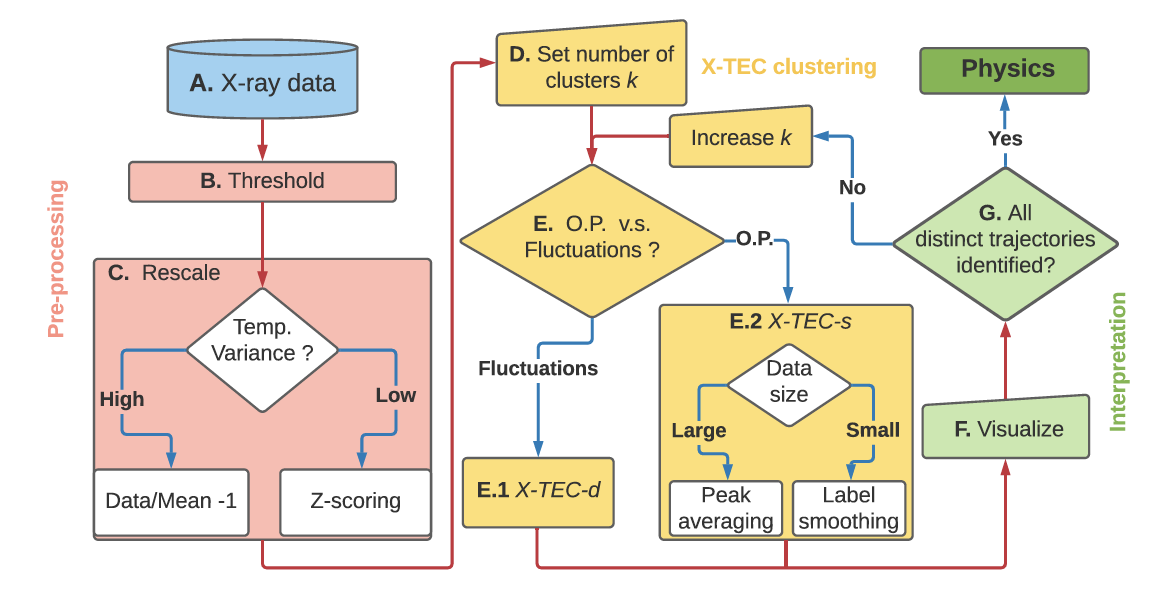

# Step A. Import the XRD Data

The data loading can be customized to the type of file and structure of data stored. 

Ultimately, one requires a temperature series of  intensity  at (Qh, Qk, Ql) points of the 3D reciprocal lattice (or equivalently in 2D reciprocal lattice) as an array with 

```
Data. shape = (num_Temperature, num_Ql, num_Qk, num_Qh) for 3D data (equivalently for 2D data).
```


#### From https://dx.doi.org/10.18126/iidy-30e7, download the data file      ```srn0_XTEC.nxs``` 

In [4]:
data_filename = 'srn0_XTEC.nxs'  # path to your datafile: srn0_XTEC.nxs

data_file = nxload(data_filename, 'r')
data = data_file['entry/data'][:, 0.0:1.0, -10.0:10.0, -15.0:15.0]

I = data.nxsignal.nxvalue    # intensities, shape= (num_Temperature, num_Ql, num_Qk, num_Qh)
Qh = data['Qh'].nxvalue      # Qh in r.l.u
Qk = data['Qk'].nxvalue      # Qk in r.l.u
Ql = data['Ql'].nxvalue      # Ql in r.l.u
Temp = data['Te'].nxvalue    # Temperatures



# Step B. Threshold background intensity 

The data is first put through a preprocessing to remove low intensity background noise. Assumes that the peaks/relevant x-ray features are sparse so that most momenta have predominantely background intensity contributions.

Cutoff automatically estimated by minimizing the Kullback-Leibler (KL) distance between the distribution of $\log[\overline{I_q(T)}]$ and a Gaussian distribution with (high intensity) sliding cutoff. See supplementary materials of  Venderley et al., https://arxiv.org/abs/2008.03275.  
 
See preprocessing.py for comments on the code 

In [5]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"[{i}] {torch.cuda.get_device_name(i)}")

# current default device index

if torch.cuda.is_available():
    print("Current device idx:", torch.cuda.current_device())

CUDA available: True
GPU count: 2
[0] Quadro GV100
[1] Quadro GV100
Current device idx: 0


In [6]:
start_time = time.time()

masked_torch    = Mask_Zeros(I,device='cuda:0')       # removes data with zero intensity. 
threshold_torch = Threshold_Background(masked_torch,device='cuda:0')    # remove low intensity background

print("Thresholding Run Time:",time.time() - start_time)


Thresholding Run Time: 0.9662492275238037


The results from thresholding are stored as


```
    1.  threshold.data_thresholded : contains  thresholded data. 
                                     Shape=(num_T, num_thresholded_data)

    2.  threshold.ind_thresholded  : contains hkl indices of the thresholded data.
                                   Shape=(num_data_thresholded, 3) for 3D or (num_data_thresholded, 2) for 2D.

    3.  threshold.thresholded      :  stores whether the corresponding pixel is removed (=0) or not (=1).
                                      Shape=(num_l, num_k, num_h) or shape=(num_k, num_h) 
```

In [7]:
Data_thresh_torch     = threshold_torch.data_thresholded  # shape=(num_temperatures, num_thresholded data)
Data_ind_torch        = threshold_torch.ind_thresholded           # contains hkl indices of the thresholded data.

print('num of original data pixels=', np.prod(I.shape[1:])) 
print('num of thresholded data pixels=', Data_thresh_torch.shape[1])

num of original data pixels= 5061021
num of thresholded data pixels= 457679


Let us see the thresholding results. Below is the distribution of intensities $(\log[\overline{I_q(T)}])$ and the truncation point (red dot) determined by thresholding. Only intensities above the truncation are retained.

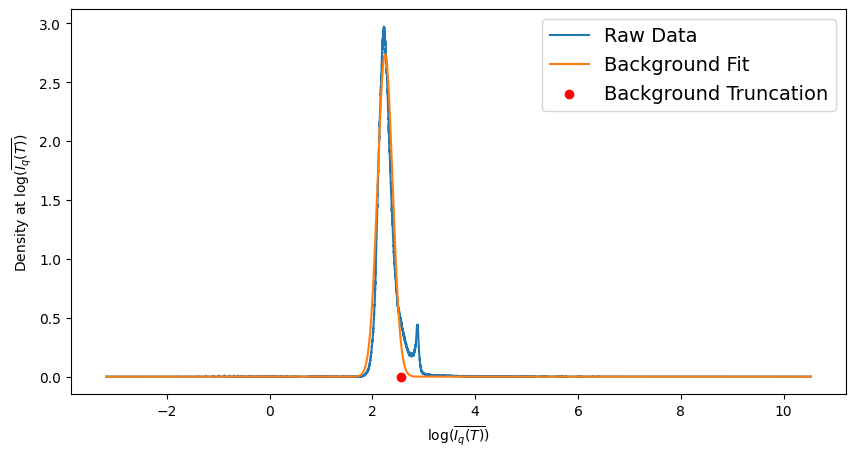

In [8]:
figsize_=(10,5)
threshold_torch.plot_cutoff(figsize_)

Note the non Gaussian features in the distribution just above the cutoff intensity (red dot). Those are the useful data we are after.

All data points that have $\log[\overline{I_q(T)}]$ above estimated cutoff are retained. The plot below shows those remaining points in the hk plane as grey clusters  

Text(0.5, 1.0, 'L=0.0')

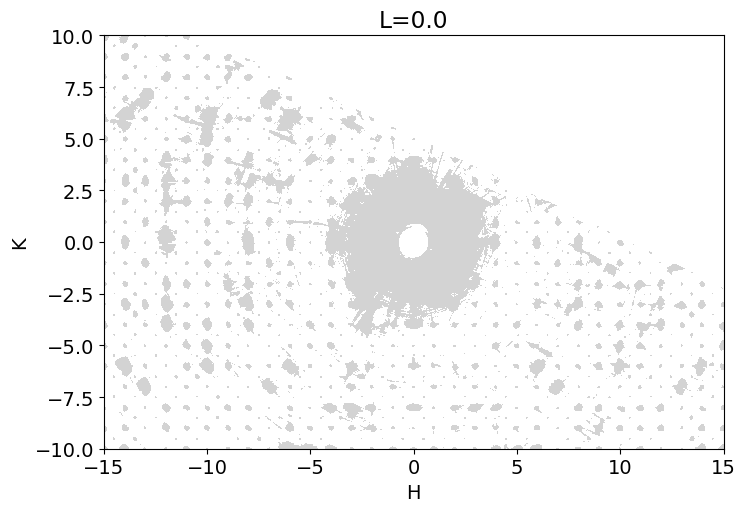

In [9]:
figsize_=(8,8)

axis_ind = 0   # Select 0 for plotting l plane, 1 for k plane, 2 for h plane
slice_value = 0.0 # Value of the axis orthogonal to the selected plane
slice_ind = data.nxaxes[axis_ind+1].index(slice_value) # index of  the selected axis (h/k/l plane) to plot

threshold_torch.plot_thresholding_2D_slice(figsize_, slice_ind, axis_ind)

# threshold.plot_thresholding_2D_slice(figsize_, slice_ind_, axis_) : plots the 2D image 
# with points whose intensity distribution is above the cutoff marked as grey. 
# if data is 3D, then set the slice ind and axis_ (default=None) to select the index of the 2D slice along axis_ =0,1 or 2.

ax = plt.gca()
ax.get_images()[0].set_extent((Qh[0], Qh[-1], Qk[0], Qk[-1])) 
plt.xlabel('H')
plt.ylabel('K')
plt.title(f'L={slice_value}')


# Step. C Rescale intensity


To reduce the large range in the scale of intensities and for efficient feature selection of the temperature trajectory, we provide two options to rescale intensities $I_q(T)$: 


#### Rescaling by mean:
subtracting and dividing their mean over temperature $\mu_{\vec{q}_i}=d_T^{-1}\sum_j I_{\vec{q}_i}(T_j)$  for each $q$,


\begin{equation}
	\tilde{I}_{\vec{q}_i}(T_j)=\dfrac{I_{\vec{q}_i}(T_j)}{\mu_{\vec{q}_i}}-1,
	\end{equation}
    
    
#### Z-scoring the data:
subtracting the mean (over T) and then dividing by standard deviation (over T) 
    
\begin{equation}
	\tilde{I}_{\vec{q}_i}(T_j)=\dfrac{I_{\vec{q}_i}(T_j)-\mu_{\vec q_i}}{\sigma_{\vec{q}_i}},
\end{equation}
    
where $\sigma_{\vec{q}_i}=\sqrt{d_T^{-1}\sum_j \left(I_{\vec{q}_i}(T_j)-\mu_{\vec q_i}\right)^2}$ is the standard deviation.
	

In [10]:
Rescaled_data_torch=threshold_torch.Rescale_mean(Data_thresh_torch)      # rescale by mean
print(Rescaled_data_torch.dtype)
#Rescaled_data=threshold.Rescale_zscore(data)   # rescale by z-score


print('num of thresholded (and rescaled) data = ', Rescaled_data_torch.shape[1] )
print('num T = ', Rescaled_data_torch.shape[0])


torch.float32
num of thresholded (and rescaled) data =  457679
num T =  24


## Optional step: remove data with low variance in temperature (for faster results)

To see faster results, and when large number of data post thresholding is made of noise, this step removes the noisy data by eliminating low variance trajectories. We have to however set the cutoff manually


In [11]:
#cutoff=0.3
#threshold.Get_High_Variance(Rescaled_data,cutoff)   # get (rescaled) data with std_dev (in T) > cutoff               
    
#Rescaled_data=threshold.data_high_std_dev        # The high variance data, shape=(num_T, num_high_var_data) 
#Data_ind    = threshold.ind_high_std_dev    # (hkl) indices of high var data, shape=(num_high_var_data,3) 


The downside is the setting of manual cutoff for this step. 
###### Recommended course of action: Cluster without any cutoff on smaller datasets.  Apply cutoff on larger datasets for faster results

# Step D: set number of clusters

Start with an initial guess (say 3 or 4), and run till step F (visualization). Revisit this step to change the num of clusters to arrive at the optimal choice. 

In [12]:
num_clusters = 4

# Step E.1:  XTEC-d  (vanilla GMM)

We first apply simple GMM clustering. Here temperature series of intensity at each $q$ point is clustered independently.  

In [13]:
Data_for_GMM_torch    = Rescaled_data_torch.T
start_time = time.time()
clusterGMM = GMM(Data_for_GMM_torch, num_clusters, trainer_params=dict(accelerator='gpu', devices=1)) # set the data and number of clusters for GMM
clusterGMM.RunEM()   # performs the simple EM algorithm to cluster trajectories
end_time = time.time()
print("GMM (GPU) Run Time:",end_time - start_time)

clusterGMM = clusterGMM
cluster_assignments = clusterGMM.cluster_assignments 
print('num of trajectories in each cluster = ', clusterGMM.num_per_cluster)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 43: 100%|██████████████████████████████| 1/1 [00:00<00:00, 125.78it/s, nll=-39.1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 1/1 [00:00<00:00, 87.09it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 1/1 [00:00<00:00, 76.15it/s]
GMM (GPU) Run Time: 1.889301061630249
num of trajectories in each cluster =  [228621, 12061, 172334, 44663]


Clustering results are stored in clusterGMM as

```
clusterGMM.cluster_assignments : cluster assignment k in range(num_clusters), of each sample. Shape=(num_data)
clusterGMM.num_per_cluster : number of trajectories in each cluster.

clusterGMM.cluster[k].mean: cluster mean trajectory (dim=num_Temperature) of the k-th cluster
clusterGMM.cluster[k].cov : cluster covariance [dim=num_Temperature] of the k-th cluster
```

### Store the clustering results:




# Step F. Visualization of clustered results.

Let us plot the cluster mean of the rescaled data (lines), with 1 standard deviation shaded, for the clusters color coded as red blue green violet etc. 

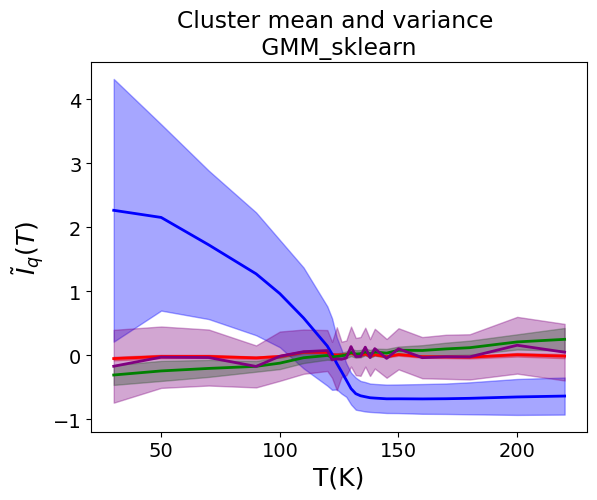

In [ ]:
clusterGMM.Plot_Cluster_Results_traj(Temp)  # Plotting for only less than 7 clusters currently enabled.  

plt.xlabel('T(K)', size=18)
plt.ylabel('$\widetilde{I}_q(T)$', size=18)
plt.title('Cluster mean and variance \n Torch GMM ');

The order parameter like behavior of one of the cluster is apparent from here, with a transition temperature $T_c\approx 130 K$ This cluster corresponds to the CDW peak. To see that, let us plot and see which pixels in the $(h,k)$ plane belong to the red/blue/green/violet cluster.   

Text(0.5, 1.0, 'L=0.0')

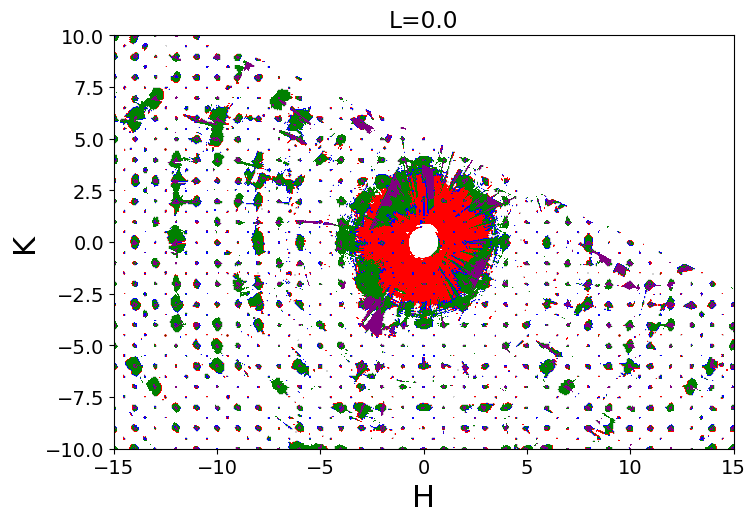

In [15]:
figsize_ = (8,8)

axis_ind = 0   # Select 0 for plotting l plane, 1 for k plane, 2 for h plane 
slice_value = 0.0 # Value of the axis orthogonal to the selected plane
slice_ind = data.nxaxes[axis_ind+1].index(slice_value) # index of  the selected axis (h/k/l plane) to plot

Data_for_GMM_ind_torch =  Data_ind_torch  #(hkl) indices of the data that was clustered 

clusterGMM.Plot_Cluster_kspace_2D_slice(threshold_torch, figsize_, Data_for_GMM_ind_torch, slice_ind, axis_ind) 

ax = plt.gca()
ax.get_images()[0].set_extent((Qh[0], Qh[-1], Qk[0], Qk[-1])) 
plt.xlabel("H", size=22)
plt.ylabel("K", size=22)
plt.title(f'L={slice_value}')

```


clusterGMM.Plot_Cluster_kspace_2D_slice(threshold,figsize_,data_ind,slice_ind,axis_ind,cluster_list=None) 
```


Plots the 2D image slice, with each (thresholded) pixel color coded by the clustering label, or colored grey if not clustered. 
The input parameters are:
```
threshold      : class Threshold_Background from Preprocessing
figsize_       : size of image. If None, will not plot the image
data_ind       : (h,k,l) or (h,k) indices of the data. shape=(num_data,2) or (num_data,3)
slice_ind      : if 3D, the h/k/l index of the selected axis along which to take the data slice. 
axis_ind       : selected axis_ of slice_ind. 0 for l, 1 for k and 2 for h axis 
```

Output attributes for ploting with imshow(),
```
clusterGMM.plot_image : 2D image to be plotted 
clusterGMM.plot_cmap  : color map for the clustering, matching the same color scheme of the cluster trajectories
clusterGMM.plot_norm  : the norm to be used in imshow() so that cmap matches the cluster assignment integers 

```

Text(0.5, 1.0, 'L=0.0')

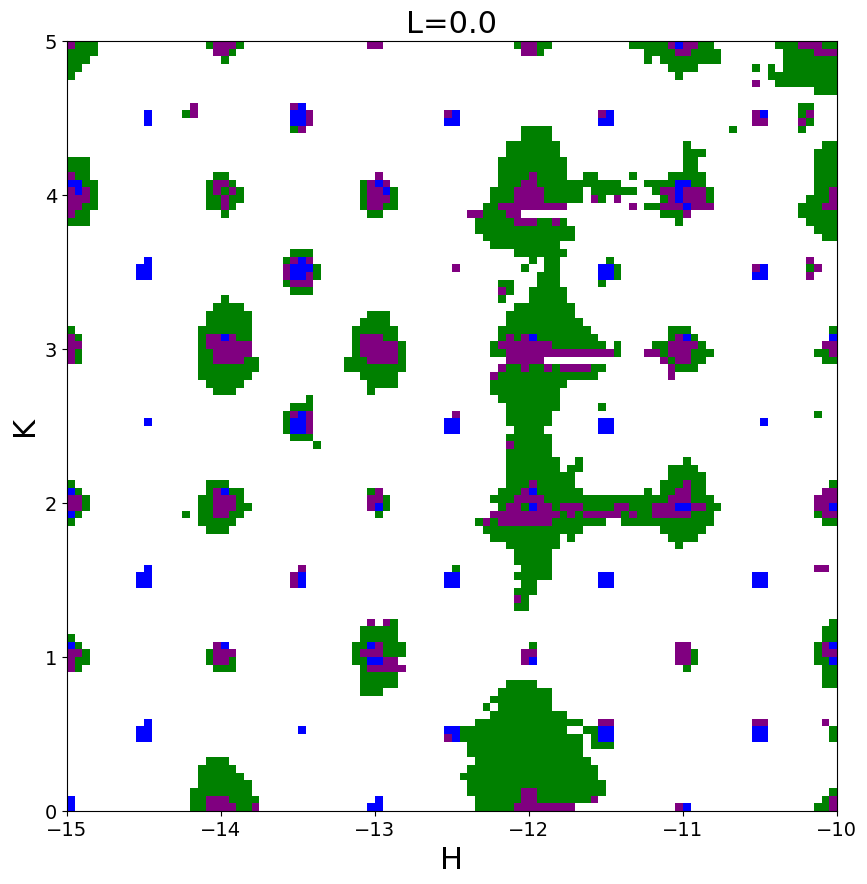

In [16]:
# a zoom in image of the above figure..
plt.figure(figsize=(10,10))

plt.imshow(clusterGMM.plot_image[200:300,0:100], origin='lower', cmap=clusterGMM.plot_cmap, norm=clusterGMM.plot_norm, extent=[Qh[0], Qh[100], Qk[200], Qk[300]])

plt.xlabel("H", size=22)
plt.ylabel("K", size=22)
plt.title(f'L={slice_value}', size=22)


Notice that CDW peaks at $q_{CDW} = (H+0.5,K+0.5,0)$ have overwhelmingly the same color matching the color of the order parameter like trajectory.





### At this point, we can already see the CDW peaks and their intensity trajectory reflecting the order parameter.  The remaining steps are only to sharpen this result.


# https://github.com/KimGroup/X-TEC

## Harnessing Interpretable and Unsupervised Machine Learning to Address Big Data from Modern X-ray Diffraction

### https://arxiv.org/abs/2008.03275 

###### Jordan Venderley,  Krishnanand Mallaya, Michael Matty, Matthew Krogstad, Jacob Ruff, Geoff Pleiss, Varsha Kishore, David Mandrus, Daniel Phelan, Lekh Poudel, Andrew Gordon Wilson, Kilian Weinberger, Puspa Upreti, M. R. Norman, Stephan Rosenkranz, Raymond Osborn, Eun-Ah Kim


### Tutorial by Krishnanand Mallayya. Adapted for Torch GPU version by Yanjun Liu and Aaditya Panigrahi. 
### For questions about X-TEC code and tutorial contact kmm537@cornell.edu (Krishnanand), yl3447@cornell.edu (Yanjun) and ap2563@cornell.edu (Aaditya).

